This script presents a PyTorch transfer learning example.

This simulation is a part of our paper: 

Kabir, H.M., Abdar, M., Jalali, S.M.J., Khosravi, A., Atiya, A.F., Nahavandi, S., and Srinivasan, D., 2020. SpinalNet: Deep Neural Network with Gradual Input. arXiv preprint arXiv:2007.03347.

For more codes:
https://github.com/dipuk0506/SpinalNet

In [1]:
'''Unzipping'''

from zipfile import ZipFile
# Create a ZipFile Object and load sample.zip in it
with ZipFile('../input/oxford-102-flower-pytorch/flower_data.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

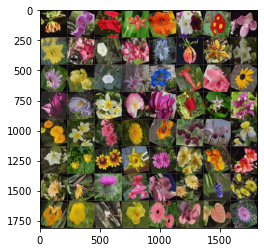

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


In [2]:

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy



plt.ion()   # interactive mode

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((230,230)),
        transforms.RandomRotation(30,),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}

data_dir = './flower_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)#, title=[class_names[x] for x in classes])

#model_ft = models.vgg19_bn(pretrained=True)
#num_ftrs = model_ft.classifier[0].in_features

model_ft = models.resnext50_32x4d(pretrained=True)
num_ftrs = model_ft.fc.in_features

half_in_size = round(num_ftrs/2)
layer_width = 102 #Small for Resnet, large for VGG
Num_class=102

In [3]:
''' Changing the fully connected layer'''


Multilayer_fc = nn.Sequential(
            nn.Linear(num_ftrs, layer_width*2),
            nn.ReLU(inplace=True),
            nn.Linear(layer_width*2, layer_width*2),
            nn.ReLU(inplace=True),
            nn.Linear(layer_width*2, Num_class)
        )


#model_ft.fc = nn.Linear(num_ftrs, 10)
model_ft.fc = Multilayer_fc#SpinalNet_ResNet() #SpinalNet_VGG # testing the effect of multilayer

In [4]:
'''The Training Function'''

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
 
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                time_elapsed = time.time() - since
                print('Time from Start {:.0f}m {:.0f}s'.format(
                    time_elapsed // 60, time_elapsed % 60))
                
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
train Loss: 3.8855 Acc: 0.1662
valid Loss: 2.4755 Acc: 0.4071
Time from Start 2m 24s

Epoch 1/9
train Loss: 1.3898 Acc: 0.6484
valid Loss: 0.6791 Acc: 0.8313
Time from Start 4m 49s

Epoch 2/9
train Loss: 0.4695 Acc: 0.8687
valid Loss: 0.5349 Acc: 0.8643
Time from Start 7m 12s

Epoch 3/9
train Loss: 0.2649 Acc: 0.9255
valid Loss: 0.4088 Acc: 0.8875
Time from Start 9m 36s

Epoch 4/9
train Loss: 0.1509 Acc: 0.9583
valid Loss: 0.3028 Acc: 0.9242
Time from Start 11m 60s

Epoch 5/9
train Loss: 0.1284 Acc: 0.9626
valid Loss: 0.3858 Acc: 0.9156

Epoch 6/9
train Loss: 0.1144 Acc: 0.9670
valid Loss: 0.2399 Acc: 0.9401
Time from Start 16m 47s

Epoch 7/9
train Loss: 0.0388 Acc: 0.9904
valid Loss: 0.1535 Acc: 0.9670
Time from Start 19m 11s

Epoch 8/9
train Loss: 0.0198 Acc: 0.9962
valid Loss: 0.1424 Acc: 0.9707
Time from Start 21m 35s

Epoch 9/9
train Loss: 0.0149 Acc: 0.9968
valid Loss: 0.1330 Acc: 0.9707

Training complete in 23m 59s
Best val Acc: 0.970660


In [6]:
'''Training again with lower lr'''
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)      
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

Epoch 0/29
train Loss: 0.0146 Acc: 0.9976
valid Loss: 0.1384 Acc: 0.9670
Time from Start 2m 24s

Epoch 1/29
train Loss: 0.0124 Acc: 0.9976
valid Loss: 0.1346 Acc: 0.9682
Time from Start 4m 48s

Epoch 2/29
train Loss: 0.0109 Acc: 0.9977
valid Loss: 0.1324 Acc: 0.9694
Time from Start 7m 12s

Epoch 3/29
train Loss: 0.0111 Acc: 0.9982
valid Loss: 0.1282 Acc: 0.9719
Time from Start 9m 37s

Epoch 4/29
train Loss: 0.0077 Acc: 0.9991
valid Loss: 0.1195 Acc: 0.9743
Time from Start 12m 2s

Epoch 5/29
train Loss: 0.0079 Acc: 0.9989
valid Loss: 0.1255 Acc: 0.9743

Epoch 6/29
train Loss: 0.0067 Acc: 0.9995
valid Loss: 0.1255 Acc: 0.9682

Epoch 7/29
train Loss: 0.0063 Acc: 0.9994
valid Loss: 0.1288 Acc: 0.9719

Epoch 8/29
train Loss: 0.0063 Acc: 0.9991
valid Loss: 0.1229 Acc: 0.9743

Epoch 9/29
train Loss: 0.0073 Acc: 0.9992
valid Loss: 0.1260 Acc: 0.9707

Epoch 10/29
train Loss: 0.0071 Acc: 0.9991
valid Loss: 0.1237 Acc: 0.9719

Epoch 11/29
train Loss: 0.0055 Acc: 0.9997
valid Loss: 0.1265 Acc: 0.9

Deleting data after use to avoid figures at the bottom.

In [7]:
import shutil
shutil.rmtree('./flower_data')